In [77]:
library(tidyverse)
library(caret)
library(randomForest)
library(ranger) #RandomForest plus rapide
library(rpart)
library(pROC)

# Introduction
L'objet de l'étude est la **classification des cyberattaques** sur les appareils mobiles sous sytème Android à partir des données qui s'échangent et transitent par le smartphone, recoltées par le moniteur des ressources. Le but étant d'effectuer le traitement adapté pour nettoyer l'appareil sans avoir besoin de la réinitialiser en perdant des données personnelles.

Pour classer des appareils infectées ou non, les données du moniteur de ressources ne permettent pas de le faire puisque le téléphone attaqué arrive à avoir un comportement "normal" (sauf quelques `ransomeware`). L'analyse des logs (texte) permet de déceler les moments anormaux mais ne renseigne pas le type d'infection. Donc pour un log de réseau anormal, on récolte les données du moniteur de ressources. Nous intervenons dans cette deuxième partie.  
Les données proviennent de l'[Université du Nouveau-Brunswick](https://www.unb.ca/cic/datasets/index.html) au Canada.

Dans cette étude, l'appareil est déjà infectée et les attaques ne peuvent pas se superposer (impossibilité d'avoir plus d'une infection).  
En regroupant certaines classes de même nature, dont les variances sont très faibles, on a 4 attaques qui sont indécelables en analysant le comportement de l'appareil de façon générale:

- `adware`, qui affiche des pubs ciblées tout en espionnant de manière illégale les activités de l'appareil.
- `botnet`, qui intègre le téléphone à un réseau d'[appareils zombies](https://fr.wikipedia.org/wiki/Machine_zombie).
- `ransomeware`, qui chiffre l'intégralité des données ou uniquement une partie (le cas ici) et qui se déchiffre après avoir payé une rançon ou en utilisant un décrypteur.
- `sms`, qui installe un vers ou un cheval de Troie pour le transformer en appareil zombie.

Pour être actifs, les appareils communiquent avec les serveurs des cyberattaquants. Nous analyserons les données liées à ces échanges.

In [122]:
data <- read_csv("data/hackerAttack.csv")
dim(data)

Parsed with column specification:
cols(
  .default = col_double(),
  `Destination IP` = col_character(),
  Label = col_character()
)
See spec(...) for full column specifications.


[1] 4000   82

# I. Features Engineering
Dans nos données brutes, nous avons `r ncol(data)-1` variables et `r nrow(data)` observations.  
Pour nettoyer nos données, nous devons supprimer les colonnes constantes ou ayant de faible variance (inférieure au premier quartile des variances), transformer certaines variables:

- `Destination IP`, en facteur `IP` en ne gardant que le **Net-ID** (le 1<sup>er</sup> octet si classe A, les 2 premiers sinon)
- `Source Port` et `Destination Port`, en `SPort` et `DPort`, de num à facteur en suivant les types d'attribution de l'[IANA](https://fr.wikipedia.org/wiki/Internet_Assigned_Numbers_Authority)
- `Protocol`, de num à facteur en suivant les [assignements](https://www.iana.org/assignments/protocol-numbers/protocol-numbers.xhtml) de l'IANA
- `Label`, nos variables à expliquer $Y$ en facteur.
- Les variables quantitatives, standardisées.

In [79]:
ip_split <- function(ip){
    #' Renvoie le Net-ID d'une adresse IP
    octets <- str_split(ip, "\\.")[[1]]
    if (as.numeric(octets[1]) <= 127) {
        netID <- octets[1]
    } else {
        netID <- paste(octets[1], octets[2], sep = ".")
    }
    
    return(netID)
}

Transformation des IPs.

In [123]:
data <- data %>% 
rename(IP = 'Destination IP') %>% 
rowwise() %>% # vectorise la fonction ip_split
mutate(IP = ip_split(IP)) %>% 
as_tibble() # supprime rowwise_df

Les autres transformations

In [134]:
data <- data %>% 
rename(
    SPort = 'Source Port',
    DPort = 'Destination Port',
) %>% 
mutate(
    DPort = case_when(
        DPort == 53 ~ "DNS",
        DPort == 80 ~ "HTTP",
        DPort == 443 ~ "HTTPS",
        DPort %in% c(1024:5000, 49152:65535) ~ "Microsoft RPC",
        DPort %in% 60000:61000 ~ "Mosh",
        TRUE ~ "Private"
    ),
    SPort = case_when(
        SPort == 80 ~ "HTTP",
        SPort == 443 ~ "HTTPS",
        SPort %in% c(1024:5000, 49152:65535) ~ "Microsoft RPC",
        SPort %in% 60000:61000 ~ "Mosh",
        TRUE ~ "Private"
    )
) %>% 
mutate_at(
    c('SPort', 'DPort', 'IP', 'Protocol', 'Label'),
    funs(factor)
) %>% 
select(
    1:4, # Facteurs
    colnames(select_if(., function(col) is.numeric(col) && var(col) >= 21.87)), # Variances faibles
    ncol(.) # Label
) %>% 
mutate_if(
    is.numeric,
    scale
)

In [98]:
dim_quant <- data %>% select_if(is.numeric) %>% ncol()
dim_IP <- length(unique(data$IP))
dim_SPort <- length(unique(data$SPort))
dim_DPort <- length(unique(data$DPort))
dim_Protocol <- length(unique(data$Protocol))
dim_X <- dim_quant + dim_IP-1 + dim_SPort-1 + dim_DPort-1 + dim_Protocol-1

Nous obtenons une dimension de `r dim(data)` après nettoyage.

Un total de `r dim_X` variables explicatives:

- `r dim_quant` variables quantitatives.
- `r dim_IP` modalités de IP.
- `r dim_SPort` modalités de SPort
- `r dim_DPort` modalités de DPort
- `r dim_Protocol` modalités de Protocol.

On ne peut pas utiliser l'ACP pour réduire les dimensions puisque les variables ne sont pas linéaires. La stratégie sera d'éliminer les variables qui ne sont pas importantes pour les modèles de classifications.

In [121]:
data %>% 
select_if(is.numeric) %>% var()

,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
Source Port,2.791952e+08,-1.830285e+08,-1.920768e+03,2.060199e+10,3.084455e+04,3.442362e+04,4.744752e+06,3.141817e+07,1.167117e+06,-2.474050e+05,...,7.028629e+03,-1.831331e+03,2.833224e+08,-5.697348e+07,2.341213e+08,3.290330e+08,-1.562027e+09,-2.286745e+09,-3.669247e+09,2.546096e+08
Destination Port,-1.830285e+08,2.004956e+08,-1.111044e+03,-3.881053e+10,-3.250216e+04,-4.664341e+04,-2.262227e+06,-5.725548e+07,-7.609651e+05,2.461132e+05,...,-4.492369e+03,7.767252e+03,-1.204706e+08,1.108845e+08,-2.196288e+07,-2.063377e+08,-8.992576e+09,1.683773e+09,-7.595779e+09,-1.026469e+10
Protocol,-1.920768e+03,-1.111044e+03,5.592273e+00,-1.057638e+07,-3.540635e+00,-4.439460e+00,-2.293820e+02,-5.358998e+03,-8.782663e+01,1.503720e+01,...,-2.675106e-01,3.476619e+00,-6.310050e+04,-1.097311e+04,-7.016759e+04,-5.444237e+04,-3.577173e+06,-4.274271e+05,-3.968073e+06,-3.257967e+06
Flow Duration,2.060199e+10,-3.881053e+10,-1.057638e+07,6.010884e+14,7.876316e+07,7.386514e+07,1.483764e+10,3.010217e+10,2.356806e+09,-1.322875e+08,...,2.619318e+07,-3.188374e+07,6.995691e+12,1.602420e+12,8.627224e+12,5.753368e+12,2.658168e+14,2.986575e+13,2.942289e+14,2.430201e+14
Total Fwd Packets,3.084455e+04,-3.250216e+04,-3.540635e+00,7.876316e+07,6.528160e+03,1.470504e+04,3.960265e+04,2.106473e+07,4.100420e+03,-8.070833e+01,...,6.283236e+01,1.603101e+01,3.952891e+06,8.922719e+05,4.727000e+06,3.271720e+06,5.913768e+07,4.800690e+06,6.360319e+07,5.547191e+07
Total Backward Packets,3.442362e+04,-4.664341e+04,-4.439460e+00,7.386514e+07,1.470504e+04,3.363773e+04,4.919701e+04,4.829659e+07,5.955307e+03,-9.291760e+01,...,9.124364e+01,3.067381e+01,4.497917e+06,8.223541e+05,5.184818e+06,3.878372e+06,6.011216e+07,3.693830e+06,6.326209e+07,5.728768e+07
Total Length of Fwd Packets,4.744752e+06,-2.262227e+06,-2.293820e+02,1.483764e+10,3.960265e+04,4.919701e+04,5.218006e+07,1.971003e+07,2.366096e+06,3.546421e+03,...,2.747070e+04,2.410629e+03,1.361683e+09,1.776363e+08,1.507656e+09,1.229738e+09,1.342276e+10,1.131997e+09,1.439820e+10,1.258147e+10
Total Length of Bwd Packets,3.141817e+07,-5.725548e+07,-5.358998e+03,3.010217e+10,2.106473e+07,4.829659e+07,1.971003e+07,6.945616e+10,4.783662e+06,-1.279116e+05,...,8.226222e+04,3.586013e+04,2.966384e+09,2.299251e+08,3.073557e+09,2.813856e+09,2.819764e+10,-2.345046e+09,2.563650e+10,3.003256e+10
Fwd Packet Length Max,1.167117e+06,-7.609651e+05,-8.782663e+01,2.356806e+09,4.100420e+03,5.955307e+03,2.366096e+06,4.783662e+06,4.105365e+05,2.953492e+03,...,1.428952e+03,3.085686e+02,1.377460e+08,2.218020e+07,1.554033e+08,1.214649e+08,2.582000e+09,2.353296e+08,2.779791e+09,2.414302e+09
Fwd Packet Length Min,-2.474050e+05,2.461132e+05,1.503720e+01,-1.322875e+08,-8.070833e+01,-9.291760e+01,3.546421e+03,-1.279116e+05,2.953492e+03,5.624869e+03,...,-1.051275e+01,1.626741e+01,-1.206906e+06,-2.246112e+05,-1.410960e+06,-1.034180e+06,-4.199655e+07,-3.109427e+06,-4.468958e+07,-3.974797e+07


In [120]:
data %>% 
select_if(is.numeric) %>% 
summarise_all(var) %>% 
gather() %>%
select(value) %>% as.matrix() %>% quantile(0.25)

25% 
21.871

In [ ]:
ggplot(data) + aes(x = IP) + geom_histogram(stat="count")

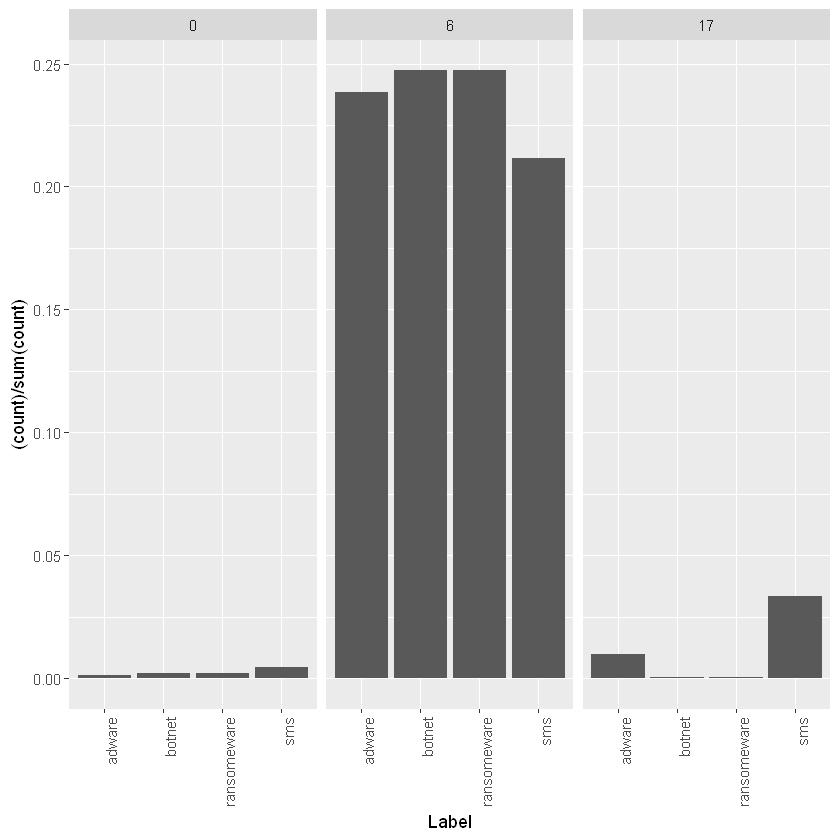

In [16]:
ggplot(df) + 
  aes(x = Label) + geom_bar(aes(y = (..count..)/sum(..count..))) + 
  facet_grid(.~Protocol) +
  theme(axis.text.x=element_text(angle=90, hjust=1))

In [22]:
length(unique(df$`Destination Port`))

[1] 325

In [71]:
ip_split <- function(ip){
    ipMain <- paste(str_split(ip, "\\.")[[1]][1], str_split(ip, "\\.")[[1]][2], sep = ".")
    return(ipMain)
}


In [76]:
df %>%
select(IP = `Destination IP`) %>% rowwise() %>% mutate(sub_label = paste(str_split(`IP`, "\\.")[[1]][1], str_split(`IP`, "\\.")[[1]][2], sep = "."))

IP,sub_label
169.53.71.249,169.53
10.42.0.211,10.42
172.217.0.228,172.217
10.42.0.211,10.42
172.217.0.228,172.217
172.217.0.228,172.217
172.217.0.228,172.217
10.42.0.211,10.42
172.217.0.228,172.217
172.217.0.228,172.217


In [27]:
df  %>% 
group_by(`Destination IP`) %>% 
summarise(n = n()) %>% 
top_n(20)

Selecting by n


Destination IP,n
10.42.0.1,153
10.42.0.151,188
10.42.0.42,145
103.235.46.211,41
104.192.108.22,41
119.146.74.33,142
119.146.74.48,39
121.12.98.63,35
121.12.98.64,51
172.217.12.202,41


In [25]:
df  %>% 
group_by(`Source Port`) %>% 
summarise(n = n()) %>% 
top_n(10)

Selecting by n


Source Port,n
0,43
80,84
443,272
5222,7
37729,7
37838,7
38176,7
38193,7
40534,7
41091,7


In [24]:
df  %>% 
group_by(`Destination Port`) %>% 
summarise(n = n()) %>% 
top_n(10)

Selecting by n


Destination Port,n
0,43
53,152
80,1327
443,2045
1900,4
5222,13
5228,20
16100,5
48962,4
51618,4


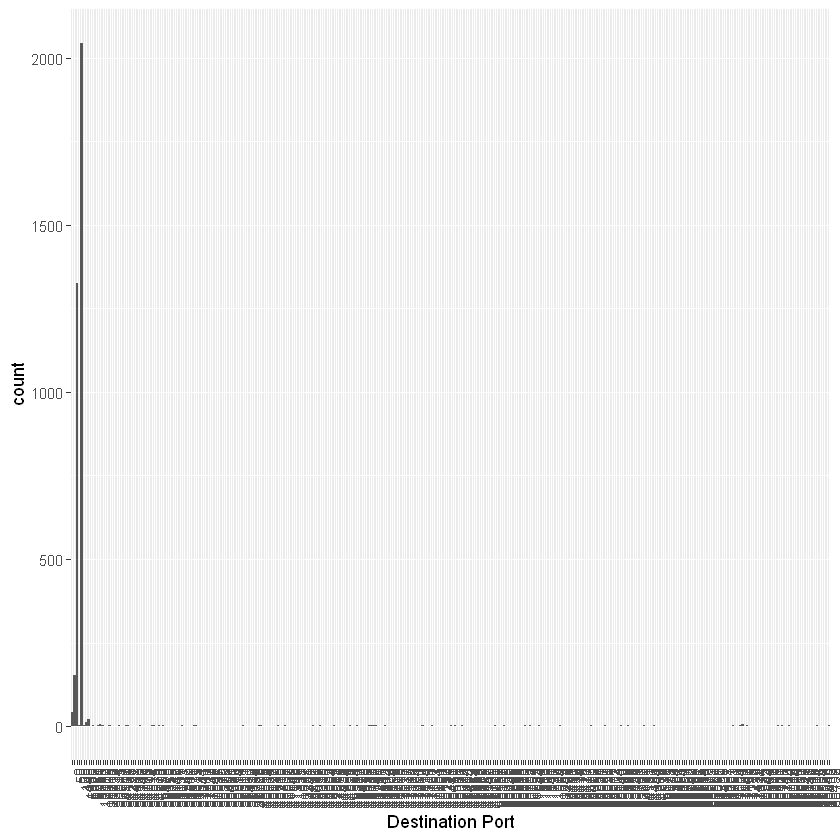

In [17]:
ggplot(df %>% mutate(`Destination Port` = as.factor(`Destination Port`))) +
  aes(x = `Destination Port`) + geom_bar() + #facet_grid(.~Label) +
  theme(axis.text.x=element_text(angle=90, hjust=1))

In [22]:
df <- tibble(
  a = 1:10,
  b = rep(2,10),
  c = c(rep(4,4), NA, rep(4,5)),
  d = 41:50
)

In [23]:
Filter(var, df)

a,d
1,41
2,42
3,43
4,44
5,45
6,46
7,47
8,48
9,49
10,50
